<a href="https://colab.research.google.com/github/AkankshaKapil/Speech_Emotion_Recognition/blob/main/A028_Speech_Emotion_Recognition_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition

The objective of this notebook is to classify from raw sound waves to six emotions: happy, sad, neutral, fear, angry, and disgust.

1. Gathering data
2. Quick EDA
3. Preprocess
4. Extract features
5. Building Models
6. Evaluate

Dataset:
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Gathering data


In [ ]:
import os
import pandas as pd
import numpy as np

In [ ]:
RAVDESS = "/content/drive/MyDrive/audio_speech_actors_01-24/"

**1. Ravdess Dataframe**

There are 1440 audio files, for example, 03-01-**06**-01-02-01-12.wav.

In [ ]:
ravdess_dir_lis = os.listdir(RAVDESS)
# Three empty lists to store information about the audio files
path_list = []
gender_list = []
emotion_list = []

# Map numerical codes to emotional labels
emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis: # This loop goes through each actor's directory
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files:
        part = audio_file.split('.')[0] # This removes the file extension from the filename
        key = part.split('-')[2] # This part contains the key for the emotion, which is a numeric code.
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}") # Append the full path of the audio file
            # checks if the least significant bit (LSB) of the
            # gender code is 0 (even) to classify the gender as 'female' or 'male'.
            gender_list.append('female' if gender_code & 1 == 0 else 'male') # Append the gender label
            emotion_list.append(emotion_dic[key]) # Append the emotion label

# These DataFrames are concatenated along the columns (axis=1) to create a single DataFrame that combines all the information.
df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

df.head()

path     sex  emotion
0  /content/drive/MyDrive/audio_speech_actors_01-...  female  neutral
1  /content/drive/MyDrive/audio_speech_actors_01-...  female    happy
2  /content/drive/MyDrive/audio_speech_actors_01-...  female  neutral
3  /content/drive/MyDrive/audio_speech_actors_01-...  female  neutral
4  /content/drive/MyDrive/audio_speech_actors_01-...  female  neutral

# 2. Quick EDA

We check for imbalances like male to female ratio.

In [ ]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

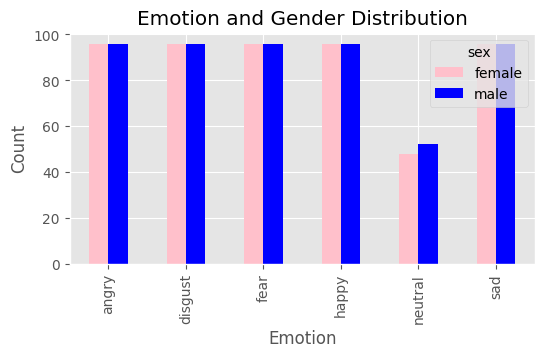

In [ ]:
def plot_distribution(df):
    # groups the input DataFrame `df` by two columns, 'emotion' and 'sex',
    # and then counts the number of occurrences in each group
    countTable = df.groupby(['emotion', 'sex']).count()

    # reshapes the data so that 'emotion' becomes the index, 'sex' becomes the columns,
    # and the values in the 'path' column are used to fill the table. Shows the count of each emotion for each gender.
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

plot_distribution(df)

In [ ]:
df.drop('sex', axis=1, inplace=True)
df.head()

In [ ]:
from IPython.display import Audio

def create_waveplot(y, sr, title): # y = audio signal(1D NumPy array), sr = no. of samples/sec
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()
def create_spectrogram(data, sr, e): # data = audio signal, sr = sample rate, e = emotion label
    # stft function converts the data into short term fourier transform.
    # STFT is a way to analyze how the frequencies in an audio signal change over time.
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X)) # Converts the magnitude of the STFT to decibels (dB)
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

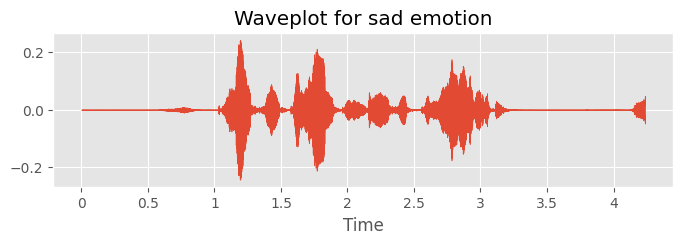

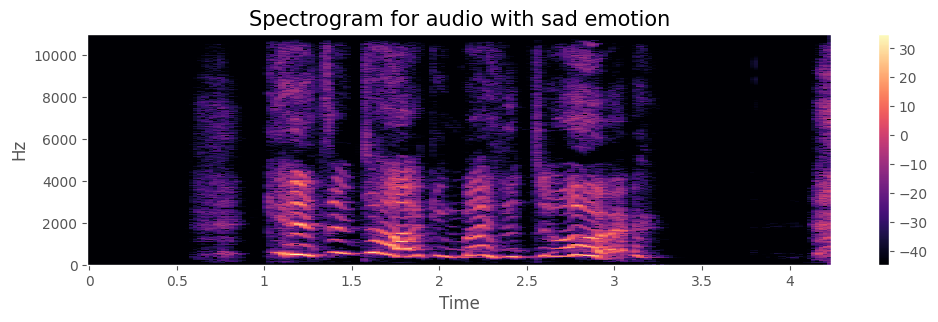

In [ ]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
create_spectrogram(y, sr, emotion_label)
Audio(path)


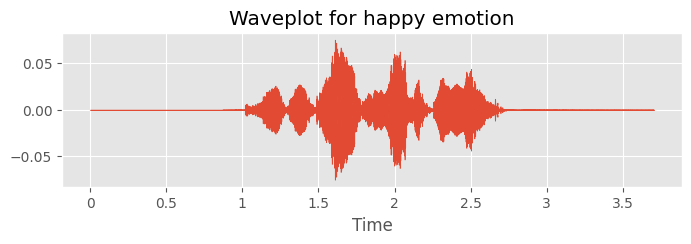

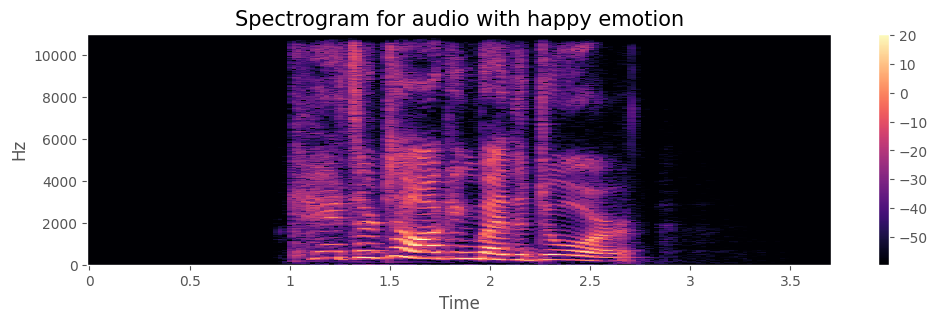

In [ ]:
emotion_label = 'happy'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
create_spectrogram(y, sr, emotion_label)
Audio(path)

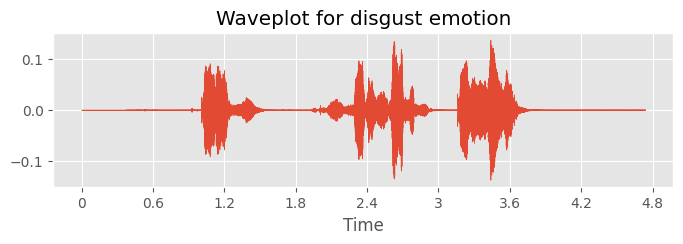

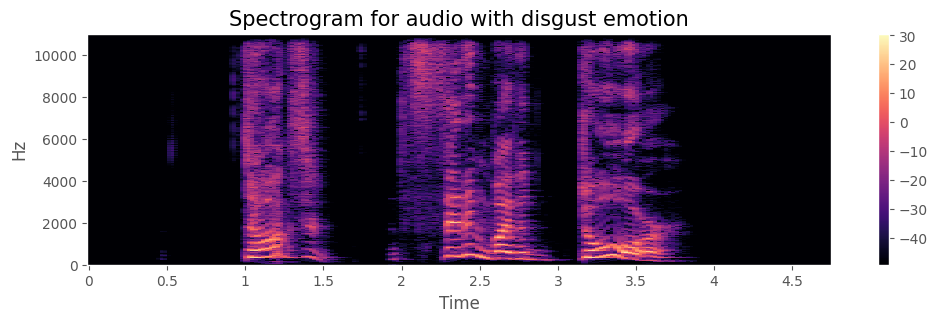

In [ ]:
emotion_label = 'disgust'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
create_spectrogram(y, sr, emotion_label)
Audio(path)

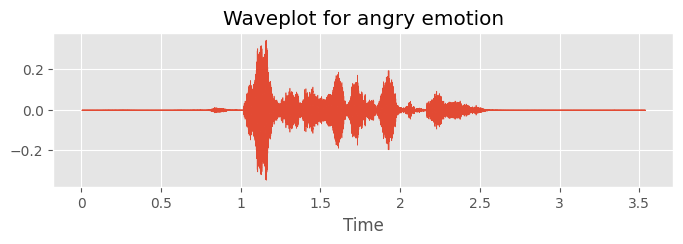

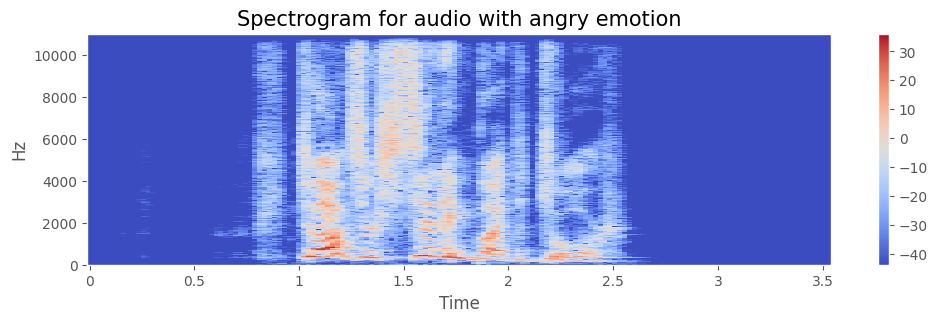

In [ ]:
emotion_label = 'angry'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
create_spectrogram(y, sr, emotion_label)

Audio(path)

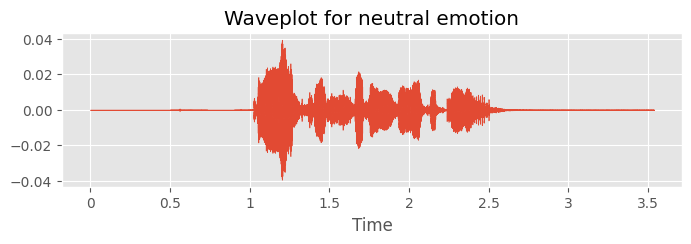

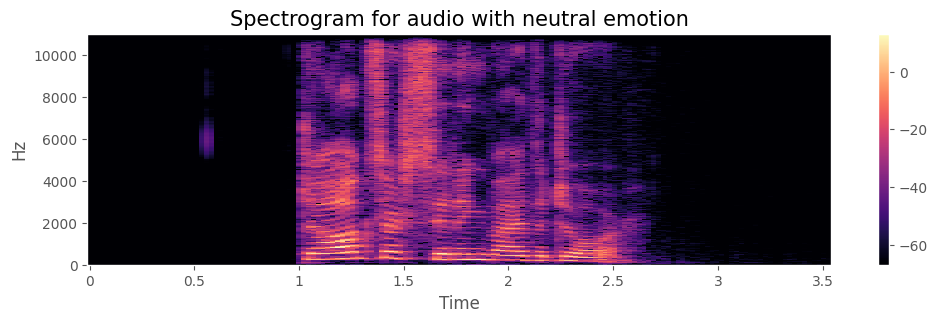

In [ ]:
emotion_label = 'neutral'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[1]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
create_spectrogram(y, sr, emotion_label)
Audio(path)

# 3. Preprocess

The following steps will be followed to preprocess the audio:

1. Get an array of samples
2. Trim the silence  
3. Padding for equal length

In [ ]:
!pip install pydub #PyDub library used for audio processing

In [ ]:
#The AudioSegment class allows you to work with audio files as objects, and the effects module provides various audio effects that can be applied to audio segments.
from pydub import AudioSegment, effects

In [ ]:
def preprocess_audio(path):
    # Load the audio file using librosa to get the sampling rate (sr)
    _, sr = librosa.load(path)

    # Load the audio file using PyDub to work with the audio data
    raw_audio = AudioSegment.from_file(path)

    # Convert the audio samples of NumPy array to type 'float32'
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')

    # Trim the audio using librosa to remove silence (top_db=25)
    trimmed, _ = librosa.effects.trim(samples, top_db=25)

    # Pad or truncate the audio to a fixed length (180000 samples in this case)
    padded = np.pad(trimmed, (0, 180000 - len(trimmed)), 'constant')

    return padded, sr


In [ ]:

# A dictionary mapping emotional labels to numerical encodings
emotion_dic = {
    'neutral': 0,
    'happy': 1,
    'sad': 2,
    'angry': 3,
    'fear': 4,
    'disgust': 5
}

# Function to encode an emotional label into its numerical representation
def encode(label):
    # Return the numerical encoding from the dictionary, or None if the label is not found
    return emotion_dic.get(label)


In [ ]:
# Function to add random noise to audio data
def noise(data):
    noise_amp = 0.04 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

# Function to stretch audio data in time
def stretch(data, rate):
    return librosa.effects.time_stretch(data, rate)

# Function to shift audio data in time
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

# Example audio file path
path = '/content/drive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01-01.wav'

# Load audio data and sampling rate
data, sample_rate = librosa.load(path)


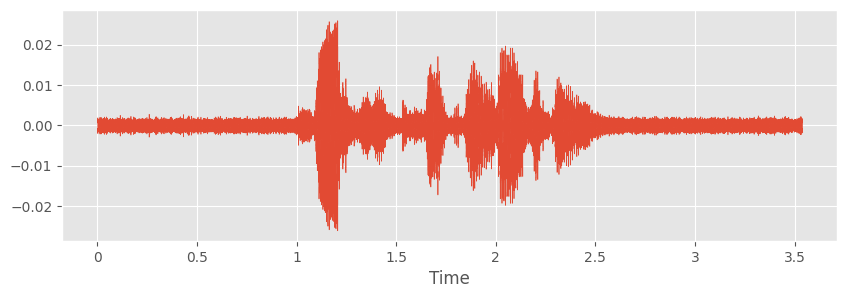

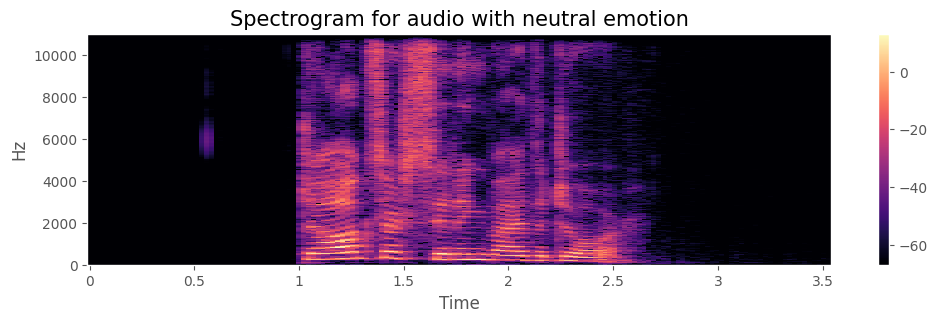

In [ ]:
# Import necessary libraries and set up the figure size
plt.figure(figsize=(10, 3))

# Apply the 'noise' function to the audio data to add random noise
x = noise(data)

# Display the waveform of the noisy audio
librosa.display.waveshow(y=x, sr=sample_rate)


create_spectrogram(y, sr, emotion_label)
# Play the noisy audio
Audio(x, rate=sample_rate)


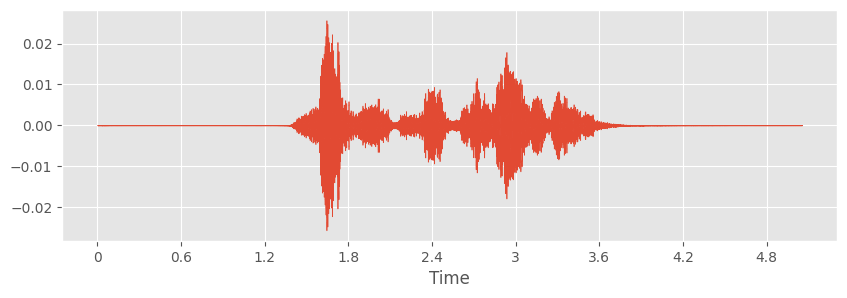

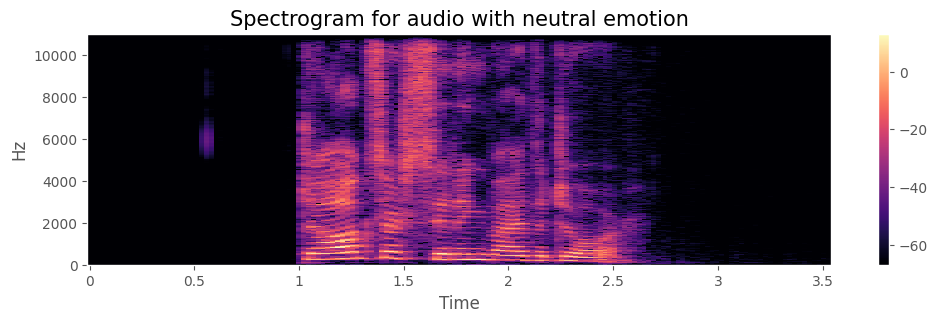

In [ ]:
# Import necessary libraries and set up the figure size
plt.figure(figsize=(10, 3))

# Apply time-stretching to the audio data with a stretch rate of 0.70
x = librosa.effects.time_stretch(data, rate=0.70)

# Display the waveform of the time-stretched audio
librosa.display.waveshow(y=x, sr=sample_rate)


create_spectrogram(y, sr, emotion_label)

# Play the time-stretched audio
Audio(x, rate=sample_rate)


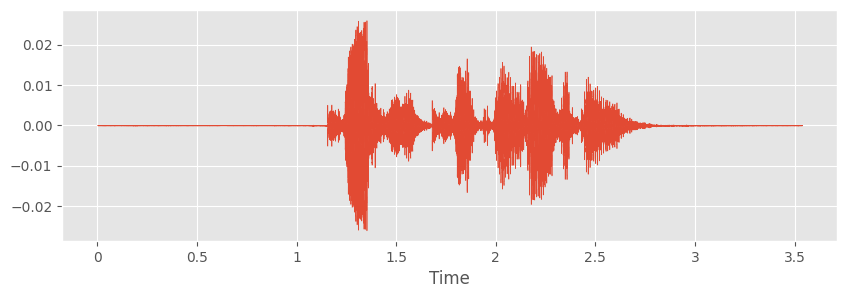

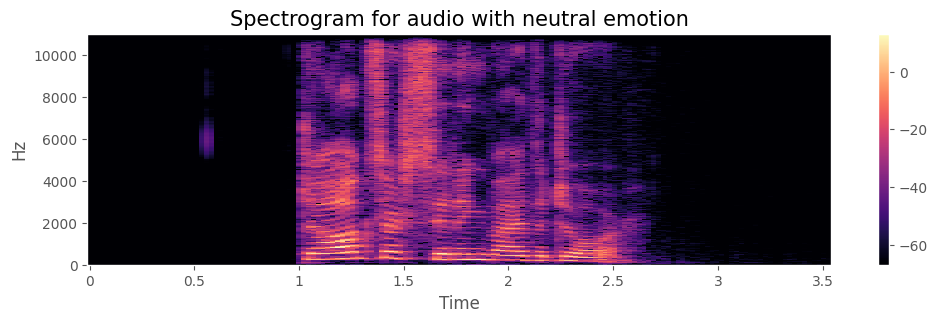

In [ ]:
plt.figure(figsize=(10,3))
x = shift(data)
librosa.display.waveshow(y=x, sr=sample_rate)
create_spectrogram(y, sr, emotion_label)
Audio(x, rate=sample_rate)

Augmenting the entire dataset

In [ ]:
from IPython.display import Audio, display

def apply_audio_augmentation(data, sample_rate):
    # Apply noise
    noisy_data = noise(data)

    # Apply time-stretching with a stretch rate of 0.70
    stretched_data = stretch(noisy_data, 0.70)

    # Apply shift
    shifted_data = shift(stretched_data)

    return shifted_data

In [ ]:
import os
import librosa
import soundfile as sf

# Directory to save the preprocessed audio files
output_directory = '/content/drive/MyDrive/augmented_data_file'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

    # Iterate through your DataFrame
    for index, row in df.iterrows():
        # Load audio data
        data, sample_rate = librosa.load(row['path'], sr=None)

        # Apply audio augmentation
        augmented_data = apply_audio_augmentation(data, sample_rate)

        # Define the output file path
        output_file_path = os.path.join(output_directory, f'augmented_{index}.wav')

        # Save the augmented audio data
        sf.write(output_file_path, augmented_data, sample_rate)


In [ ]:
import os
import pandas as pd

# Directory containing the augmented data
augmented_data_directory = '/content/drive/MyDrive/augmented_data_file'

# Lists to store information
augmented_path_list = []
augmented_gender_list = []
augmented_emotion_list = []

# Iterate over the augmented audio files
for filename in os.listdir(augmented_data_directory):
    if filename.endswith(".wav"):  # Only process .wav files
        # Construct the full file path
        file_path = os.path.join(augmented_data_directory, filename)

        # Extract index from filename
        index = int(filename.split('_')[1].split('.')[0])

        # Get the original row from the RAVDESS DataFrame
        original_row = df.iloc[index]

        # Append information to lists
        augmented_path_list.append(file_path)
        augmented_gender_list.append(original_row['sex'])
        augmented_emotion_list.append(original_row['emotion'])

# Create a DataFrame for augmented data
augmented_df = pd.DataFrame({
    'path': augmented_path_list,
    'sex': augmented_gender_list,
    'emotion': augmented_emotion_list
})


# 4. Extract features

We will only extract these features:

1. Mel-Frequency Cepstral Coefficients: captures the shape of the spectral envelope of a signal
2. Zero Crossing Rate: captures the number of times a signal changes sign per second
3. Root Mean Square Energy: captures the root mean square amplitude of the audio signal

In [ ]:
import numpy as np
import pandas as pd
import librosa
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Split the DataFrame into training and testing DataFrames
df_train, df_test = train_test_split(augmented_df, test_size=0.2, random_state=42)

# Define the directories for the train and test sets
train_dir = '/content/drive/MyDrive/train_folder'
test_dir = '/content/drive/MyDrive/test_folder'

from keras.preprocessing.sequence import pad_sequences

def process_and_save(df_subset, directory):
    # Initialize lists
    zcr_list, rms_list, mfccs_list, emotion_list = [], [], [], []

    # Define frame and hop lengths for feature extraction
    FRAME_LENGTH = 2048
    HOP_LENGTH = 512

    # Create directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    max_length = -1  # You can set this to a fixed number if you want to limit the maximum sequence length

    for row in df_subset.itertuples(index=False):
        try:
            y, sr = librosa.load(row.path, sr=None)
            zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]  # [0] to collapse the 2D array
            rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH).T  # Transpose to align time steps

            # Copy the file to the directory
            shutil.copy2(row.path, directory)

            # Append the extracted features and emotion to their respective lists
            zcr_list.append(zcr)
            rms_list.append(rms)
            mfccs_list.append(mfccs)
            emotion_list.append(row.emotion)

        except Exception as e:
            print(f"Failed for file: {row.path}, Error: {e}")

    # Find the maximum length among all features if not setting a fixed length
    if max_length < 0:
        for zcr, rms, mfccs in zip(zcr_list, rms_list, mfccs_list):
            max_length = max(max_length, zcr.shape[0], rms.shape[0], mfccs.shape[0])

    # Padding the sequences to the max_length
    zcr_list_padded = pad_sequences(zcr_list, maxlen=max_length, dtype='float32', padding='post')
    rms_list_padded = pad_sequences(rms_list, maxlen=max_length, dtype='float32', padding='post')
    mfccs_list_padded = pad_sequences(mfccs_list, maxlen=max_length, dtype='float32', padding='post')

    # Concatenate along the last axis
    X = np.concatenate((zcr_list_padded[..., np.newaxis], rms_list_padded[..., np.newaxis], mfccs_list_padded), axis=-1)

    # Convert the feature matrix to 'float32'
    X = X.astype('float32')

    # Encode string labels to integers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(emotion_list).astype('int8')

    return X, y

# Now call the process_and_save for train and test
X_train, y_train = process_and_save(df_train, train_dir)
X_test, y_test = process_and_save(df_test, test_dir)


# 5.Models

  

**1. Bidirectional LSTM, GRU using Attention Mechanism**

**We got Training Accuracy 91 percent and testing accuracy as 81 percent , We have used this model for implementation**


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (LSTM, Bidirectional, Attention, Dense, Dropout, Input,
                                    Concatenate, GlobalAveragePooling1D, BatchNormalization)
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import Adam

# One-hot encode your target values for multi-class classification
y_train_encoded = to_categorical(y_train, num_classes=6)
y_test_encoded = to_categorical(y_test, num_classes=6)

num_classes = 6

# Define input shape
input_data = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Bidirectional LSTM Layers
bi_lstm_1 = Bidirectional(LSTM(256, return_sequences=True))(input_data)
bn_bi_lstm_1 = BatchNormalization()(bi_lstm_1)
bi_lstm_2 = Bidirectional(LSTM(256, return_sequences=True))(bn_bi_lstm_1)
bn_bi_lstm_2 = BatchNormalization()(bi_lstm_2)
bi_lstm_3 = Bidirectional(GRU(128, return_sequences=True))(bn_bi_lstm_2)
bn_bi_lstm_3 = BatchNormalization()(bi_lstm_3)

# Attention Layer
attention_out = Attention()([bn_bi_lstm_3, bn_bi_lstm_3])

# Concatenate and Continue with the rest of the model
concat_out = Concatenate(axis=-1)([bn_bi_lstm_3, attention_out])
pooled_out = GlobalAveragePooling1D()(concat_out)
bn_out = BatchNormalization()(pooled_out)
dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(bn_out)
dropout_out = Dropout(0.5)(dense_out)
output = Dense(num_classes, activation='softmax')(dropout_out)

adrnn_model = Model(inputs=input_data, outputs=output)

# Compile the model with a specified learning rate
optimizer = Adam(learning_rate=0.001)
adrnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Introducing Learning Rate Scheduler
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Early Stopping with more patience
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# Train the model with smaller batch size


In [ ]:
adrnn_model.fit(X_train, y_train_encoded, epochs=30, batch_size=16, verbose=1,
                validation_data=(X_test, y_test_encoded),
                callbacks=[lr_schedule, early_stopping])

# Predictions and accuracy
y_pred_adrnn = adrnn_model.predict(X_test)
y_pred_multiclass = np.argmax(y_pred_adrnn, axis=1)
accuracy_adrnn = accuracy_score(y_test, y_pred_multiclass)
print(f'ADRNN Model Accuracy: {accuracy_adrnn:.2f}')

Epoch 1/30
27/27 [==============================] - 217s 8s/step - loss: 2.5978 - accuracy: 0.3207 - val_loss: 1.9051 - val_accuracy: 0.2170 - lr: 0.0010
Epoch 2/30
27/27 [==============================] - 212s 8s/step - loss: 2.1876 - accuracy: 0.3563 - val_loss: 1.8511 - val_accuracy: 0.3113 - lr: 0.0010
Epoch 3/30
27/27 [==============================] - 200s 7s/step - loss: 1.8419 - accuracy: 0.4133 - val_loss: 1.7634 - val_accuracy: 0.3208 - lr: 0.0010
Epoch 4/30
27/27 [==============================] - 197s 7s/step - loss: 1.5405 - accuracy: 0.5511 - val_loss: 1.7170 - val_accuracy: 0.3679 - lr: 0.0010
Epoch 5/30
27/27 [==============================] - 197s 7s/step - loss: 1.4612 - accuracy: 0.5843 - val_loss: 1.5729 - val_accuracy: 0.4811 - lr: 0.0010
Epoch 6/30
27/27 [==============================] - 197s 7s/step - loss: 1.5187 - accuracy: 0.5511 - val_loss: 1.6768 - val_accuracy: 0.4340 - lr: 0.0010
Epoch 7/30
27/27 [==============================] - 197s 7s/step - loss: 1.2

In [ ]:
adrnn_model.fit(X_train, y_train_encoded, epochs=5, batch_size=16, verbose=1,
                validation_data=(X_test, y_test_encoded),
                callbacks=[lr_schedule, early_stopping])

# Predictions and accuracy
y_pred_adrnn = adrnn_model.predict(X_test)
y_pred_multiclass = np.argmax(y_pred_adrnn, axis=1)
accuracy_adrnn = accuracy_score(y_test, y_pred_multiclass)
print(f'ADRNN Model Accuracy: {accuracy_adrnn:.2f}')

Epoch 1/5
27/27 [==============================] - 203s 8s/step - loss: 0.2225 - accuracy: 0.9952 - val_loss: 0.9047 - val_accuracy: 0.8019 - lr: 1.0000e-04
Epoch 2/5
27/27 [==============================] - 200s 7s/step - loss: 0.2483 - accuracy: 0.9881 - val_loss: 1.0231 - val_accuracy: 0.8302 - lr: 1.0000e-04
Epoch 3/5
27/27 [==============================] - 203s 8s/step - loss: 0.2271 - accuracy: 0.9929 - val_loss: 1.0173 - val_accuracy: 0.7358 - lr: 1.0000e-04
Epoch 4/5
27/27 [==============================] - 195s 7s/step - loss: 0.2276 - accuracy: 0.9929 - val_loss: 0.9811 - val_accuracy: 0.7830 - lr: 1.0000e-04
Epoch 5/5
4/4 [==============================] - 7s 2s/step
ADRNN Model Accuracy: 0.81


## Some Other Models we tried

**2. Bidirectional GRU with Attention Layer**

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Attention, Concatenate, GlobalAveragePooling1D, Dropout, BatchNormalization,Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

y_train_encoded = to_categorical(y_train, num_classes=6)
y_test_encoded = to_categorical(y_test, num_classes=6)

# Define input shape
input_data = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Bidirectional GRU Layers
bi_gru_1 = Bidirectional(GRU(128, return_sequences=True))(input_data)
bn_bi_gru_1 = BatchNormalization()(bi_gru_1)
bi_gru_2 = Bidirectional(GRU(128, return_sequences=True))(bn_bi_gru_1)
bn_bi_gru_2 = BatchNormalization()(bi_gru_2)
bi_gru_3 = Bidirectional(GRU(64, return_sequences=True))(bn_bi_gru_2)
bn_bi_gru_3 = BatchNormalization()(bi_gru_3)

# Attention Layer
attention_out = Attention()([bn_bi_gru_3, bn_bi_gru_3])

# Concatenate and Continue with the rest of the model
concat_out = Concatenate(axis=-1)([bn_bi_gru_3, attention_out])
pooled_out = GlobalAveragePooling1D()(concat_out)
bn_out = BatchNormalization()(pooled_out)
dense_out = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(bn_out)
dropout_out = Dropout(0.5)(dense_out)
output = Dense(6, activation='softmax')(dropout_out)

# Compile and train the model
gru_attention_model = Model(inputs=input_data, outputs=output)
optimizer = Adam(learning_rate=0.001)
gru_attention_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Introducing Learning Rate Scheduler
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Early Stopping with more patience
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# Train the model with smaller batch size

In [ ]:

gru_attention_model.fit(X_train, y_train_encoded, epochs=50, batch_size=16, verbose=1,
                        validation_data=(X_test, y_test_encoded),
                        callbacks=[lr_schedule, early_stopping])

# Predictions and accuracy
y_pred_gru_attention = gru_attention_model.predict(X_test)
y_pred_multiclass_gru_attention = np.argmax(y_pred_gru_attention, axis=1)
accuracy_gru_attention = accuracy_score(y_test, y_pred_multiclass_gru_attention)
print(f'GRU with Attention Model Accuracy: {accuracy_gru_attention:.2f}')

Epoch 1/50
27/27 [==============================] - 52s 2s/step - loss: 2.0869 - accuracy: 0.3017 - val_loss: 1.9312 - val_accuracy: 0.1604 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 46s 2s/step - loss: 1.7462 - accuracy: 0.4014 - val_loss: 1.8168 - val_accuracy: 0.2358 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 46s 2s/step - loss: 1.5752 - accuracy: 0.4584 - val_loss: 1.7267 - val_accuracy: 0.3491 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 57s 2s/step - loss: 1.4225 - accuracy: 0.5249 - val_loss: 1.5328 - val_accuracy: 0.4057 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 46s 2s/step - loss: 1.4473 - accuracy: 0.5416 - val_loss: 1.4233 - val_accuracy: 0.4717 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 45s 2s/step - loss: 1.3122 - accuracy: 0.5796 - val_loss: 1.3351 - val_accuracy: 0.4906 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 44s 2s/step - loss: 1.1438 - a

In [ ]:
gru_attention_model.save('/content/drive/MyDrive/gru/')

In [ ]:
gru_attention_model.save('/content/drive/MyDrive/GRU.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**3. Conv1D Bidirectional LSTM Attention Mechanism**


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Bidirectional, LSTM, Dense, Dropout, Permute, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# One-hot encode your target values for multi-class classification
y_train_encoded = to_categorical(y_train, num_classes=6)
y_test_encoded = to_categorical(y_test, num_classes=6)

# Define input shape
input_data = Input(shape=(X_train.shape[1], X_train.shape[2]))

# CNN Layers
conv1 = Conv1D(64, kernel_size=3, padding='same')(input_data)
bn1 = BatchNormalization()(conv1)
act1 = Activation('relu')(bn1)
conv2 = Conv1D(64, kernel_size=3, padding='same')(act1)
bn2 = BatchNormalization()(conv2)
act2 = Activation('relu')(bn2)

# Bidirectional LSTM Layer
bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(act2)

# Attention Layer
attention = Dense(1, activation='tanh')(bi_lstm)
attention = Lambda(lambda x: K.squeeze(x, axis=-1))(attention)
attention = Activation('softmax')(attention)
attention = Lambda(lambda x: K.expand_dims(x, axis=-1))(attention)

# Apply Attention to LSTM Layer
sent_representation = Multiply()([bi_lstm, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)


# Fully Connected Layer
dense1 = Dense(64, activation='relu')(sent_representation)
dropout1 = Dropout(0.5)(dense1)
output = Dense(6, activation='softmax')(dropout1)

# Build and Compile Model
model = Model(inputs=input_data, outputs=output)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train Model
history = model.fit(X_train, y_train_encoded, epochs=30, batch_size=16, verbose=1,
                    validation_data=(X_test, y_test_encoded),
                    callbacks=[lr_schedule, early_stopping])
# Evaluate Model
accuracy = model.evaluate(X_test, y_test_encoded)[1]
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/30
27/27 [==============================] - 20s 457ms/step - loss: 1.6840 - accuracy: 0.2850 - val_loss: 1.8044 - val_accuracy: 0.2264 - lr: 0.0010
Epoch 2/30
27/27 [==============================] - 12s 441ms/step - loss: 1.6179 - accuracy: 0.3135 - val_loss: 1.7006 - val_accuracy: 0.2453 - lr: 0.0010
Epoch 3/30
27/27 [==============================] - 12s 434ms/step - loss: 1.5650 - accuracy: 0.3302 - val_loss: 1.6433 - val_accuracy: 0.2830 - lr: 0.0010
Epoch 4/30
27/27 [==============================] - 11s 419ms/step - loss: 1.4742 - accuracy: 0.3729 - val_loss: 1.4737 - val_accuracy: 0.4151 - lr: 0.0010
Epoch 5/30
27/27 [==============================] - 10s 365ms/step - loss: 1.3606 - accuracy: 0.4703 - val_loss: 1.4411 - val_accuracy: 0.4434 - lr: 0.0010
Epoch 6/30
27/27 [==============================] - 12s 438ms/step - loss: 1.3898 - accuracy: 0.4442 - val_loss: 1.3753 - val_accuracy: 0.4151 - lr: 0.0010
Epoch 7/30
27/27 [==============================] - 13s 474ms/st

In [ ]:
history = model.fit(X_train, y_train_encoded, epochs=30, batch_size=16, verbose=1,
                    validation_data=(X_test, y_test_encoded),
                    callbacks=[lr_schedule, early_stopping])

# Evaluate Model
accuracy = model.evaluate(X_test, y_test_encoded)[1]
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/30
27/27 [==============================] - 12s 446ms/step - loss: 0.3381 - accuracy: 0.8907 - val_loss: 0.7723 - val_accuracy: 0.7075 - lr: 1.0000e-04
Epoch 2/30
27/27 [==============================] - 12s 446ms/step - loss: 0.2850 - accuracy: 0.9097 - val_loss: 0.7937 - val_accuracy: 0.7358 - lr: 1.0000e-04
Epoch 3/30
27/27 [==============================] - 12s 440ms/step - loss: 0.2833 - accuracy: 0.9169 - val_loss: 0.8516 - val_accuracy: 0.7075 - lr: 1.0000e-04
Epoch 4/30
27/27 [==============================] - 10s 365ms/step - loss: 0.3213 - accuracy: 0.8836 - val_loss: 0.7521 - val_accuracy: 0.7264 - lr: 1.0000e-04
Epoch 5/30
27/27 [==============================] - 12s 442ms/step - loss: 0.2777 - accuracy: 0.9192 - val_loss: 0.7521 - val_accuracy: 0.7170 - lr: 1.0000e-04
Epoch 6/30
27/27 [==============================] - 12s 448ms/step - loss: 0.2822 - accuracy: 0.9192 - val_loss: 0.7830 - val_accuracy: 0.7453 - lr: 1.0000e-04
Epoch 7/30
27/27 [======================

**4 .Ensemble learning architecture diagram with CNN and traditional models**


In [ ]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# One-hot encode your target values for multi-class classification
y_train_encoded = to_categorical(y_train, num_classes=6)
y_test_encoded = to_categorical(y_test, num_classes=6)

print("X_train shape:", X_train.shape)
print("y_train_encoded shape:", y_train_encoded.shape)
print("X_test shape:", X_test.shape)
print("y_test_encoded shape:", y_test_encoded.shape)

# Modify CNN model with Batch Normalization and LeakyReLU
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=3),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(128),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

# Introducing Learning Rate Scheduler
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Compile and train the CNN model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, verbose=1, validation_data=(X_test, y_test_encoded), callbacks=[lr_schedule])

# Make predictions using the CNN model
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)  # Convert one-hot encoded predictions to class labels

# Reshape the input data to be two-dimensional
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Create multiple weak learners (different classifier types)
weak_learners = [
    DecisionTreeClassifier(max_depth=1),
    SVC(kernel='linear', probability=True),
    RandomForestClassifier(n_estimators=100)
]

# Train weak learners and collect their predictions
weak_learners_predictions = []
for learner in weak_learners:
    learner.fit(X_train_flattened, y_train)
    y_pred_weak = learner.predict(X_test_flattened)
    weak_learners_predictions.append(y_pred_weak)

# Use XGBoost for classification with weak learners
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train_flattened, y_train)
y_pred_xgb = xgb_model.predict(X_test_flattened)

# Ensemble predictions using majority voting
from scipy.stats import mode

all_predictions = np.vstack([y_pred_cnn, y_pred_xgb] + weak_learners_predictions)
ensemble_predictions = mode(all_predictions, axis=0)[0].squeeze()

ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print(f'Ensemble Model Accuracy: {ensemble_accuracy:.2f}')


X_train shape: (421, 352, 15)
y_train_encoded shape: (421, 6)
X_test shape: (106, 352, 15)
y_test_encoded shape: (106, 6)
Epoch 1/30
14/14 [==============================] - 10s 215ms/step - loss: 1.7497 - accuracy: 0.3302 - val_loss: 10.2664 - val_accuracy: 0.3396 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - 2s 161ms/step - loss: 1.4035 - accuracy: 0.4941 - val_loss: 4.7858 - val_accuracy: 0.2830 - lr: 0.0010
Epoch 3/30
14/14 [==============================] - 3s 178ms/step - loss: 1.2051 - accuracy: 0.5321 - val_loss: 3.7510 - val_accuracy: 0.2358 - lr: 0.0010
Epoch 4/30
14/14 [==============================] - 4s 262ms/step - loss: 1.0740 - accuracy: 0.5796 - val_loss: 2.8145 - val_accuracy: 0.2736 - lr: 0.0010
Epoch 5/30
14/14 [==============================] - 2s 169ms/step - loss: 1.0157 - accuracy: 0.6200 - val_loss: 3.8727 - val_accuracy: 0.2264 - lr: 0.0010
Epoch 6/30
14/14 [==============================] - 2s 153ms/step - loss: 0.8632 - accuracy: 0.7031 -

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-82-46e613cbc8bb>:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  learner.fit(X_train_flattened, y_train)


Ensemble Model Accuracy: 0.74


**5. Convolutional Neural Network with Residual Connections and Self-Attention**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, Dense, Dropout, MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score

# Data preparation remains the same
y_train_encoded = to_categorical(y_train, num_classes=6)
y_test_encoded = to_categorical(y_test, num_classes=6)
# Define input shape
input_data = Input(shape=(X_train.shape[1], X_train.shape[2]))

# 1D Convolutional Layers with Residual Connections
def convolution_block(x, filters, kernel_size=3):
    conv = Conv1D(filters, kernel_size=kernel_size, padding='same', kernel_regularizer=l2(0.01))(x)
    bn = BatchNormalization()(conv)
    act = Activation('relu')(bn)
    return act

x = convolution_block(input_data, 64)
for _ in range(3):  # Three additional convolution blocks
    x_res = x
    x = convolution_block(x, 64)
    x = Add()([x, x_res])

# Self-Attention Layer
attention = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
attention = LayerNormalization(epsilon=1e-6)(attention + x)

# Global Average Pooling Layer
global_avg_pool = GlobalAveragePooling1D()(attention)

# Fully Connected Layer
dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(global_avg_pool)  # Increased to 128 units
dropout1 = Dropout(0.4)(dense1)  # Reduced dropout
output = Dense(6, activation='softmax')(dropout1)

# Build and Compile Model
model = Model(inputs=input_data, outputs=output)
optimizer = RMSprop(learning_rate=0.001)  # Changed to RMSprop
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)




In [ ]:
history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32,  # Increased epochs, adjusted batch size
                    validation_data=(X_test, y_test_encoded),
                    callbacks=[lr_schedule, early_stopping, checkpoint])

best_model = tf.keras.models.load_model("best_model.h5")
accuracy = best_model.evaluate(X_test, y_test_encoded)[1]
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/100
14/14 [==============================] - 21s 1s/step - loss: 4.5634 - accuracy: 0.2257 - val_loss: 5.0334 - val_accuracy: 0.1981 - lr: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 13s 873ms/step - loss: 4.0099 - accuracy: 0.2613 - val_loss: 4.1280 - val_accuracy: 0.2358 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - 13s 893ms/step - loss: 3.6808 - accuracy: 0.3254 - val_loss: 3.8281 - val_accuracy: 0.2075 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - 14s 1s/step - loss: 3.3483 - accuracy: 0.3254 - val_loss: 3.4094 - val_accuracy: 0.2830 - lr: 0.0010
Epoch 5/100
14/14 [==============================] - 14s 941ms/step - loss: 3.1218 - accuracy: 0.3587 - val_loss: 3.7723 - val_accuracy: 0.1981 - lr: 0.0010
Epoch 6/100
14/14 [==============================] - 14s 995ms/step - loss: 2.8967 - accuracy: 0.3492 - val_loss: 3.5502 - val_accuracy: 0.1981 - lr: 0.0010
Epoch 7/100
14/14 [==============================] - 14s 982ms/step - loss: 2.6686 - accuracy: 0.3824 - val_loss: 3.0857 - val_accuracy: 0.2358 - lr: 0.0010
Epoch 8/100
14/14 [==============================] - 13s 973ms/step - los

In [ ]:
adrnn_model.save('/content/drive/MyDrive/adrnn81/')

In [ ]:
adrnn_model.save('/content/drive/MyDrive/adrnn81.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Predictions**

In [ ]:
adrnn_model = tf.keras.models.load_model('/content/drive/MyDrive/adrnn81.h5')


In [ ]:
import tensorflow as tf
import librosa
import numpy as np
from pydub import AudioSegment, effects

# Load the saved model
adrnn_model = tf.keras.models.load_model('/content/drive/MyDrive/adrnn81.h5')

# Function to preprocess audio
def preprocess_audio(path):
    # Load the audio file using librosa to get the sampling rate (sr)
    _, sr = librosa.load(path)

    # Load the audio file using PyDub to work with the audio data
    raw_audio = AudioSegment.from_file(path)

    # Convert the audio samples of NumPy array to type 'float32'
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')

    # Trim the audio using librosa to remove silence (top_db=25)
    trimmed, _ = librosa.effects.trim(samples, top_db=25)

    # Pad or truncate the audio to a fixed length (180000 samples in this case)
    padded = np.pad(trimmed, (0, 180000 - len(trimmed)), 'constant')

    return padded, sr

# Function to extract features from audio data
def extract_features(data, sr):
    # Extract audio features: Zero Crossing Rate, RMS, and MFCCs
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=2048, hop_length=512)
    rms = librosa.feature.rms(y=data, frame_length=2048, hop_length=512)
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, hop_length=512)

    # Concatenate the extracted audio features along the second axis
    features = np.concatenate((zcr, rms, mfccs), axis=0)

    # Swap axes to have the feature dimensions correctly ordered
    features = np.swapaxes(features, 0, 1)

    return features

# Test the model on a specific audio file
audio_file_path = '/content/drive/MyDrive/Audio male.wav'
audio_data, sample_rate = preprocess_audio(audio_file_path)
features = extract_features(audio_data, sample_rate)

# Reshape the features to match the expected input shape of the model
features = features.reshape(1, features.shape[0], features.shape[1])

# Make prediction
predictions = adrnn_model.predict(features)

# Get the class with the highest probability
predicted_class = np.argmax(predictions)

# Print the result
print("Predicted Emotion Class:", predicted_class)


1/1 [==============================] - 4s 4s/step
Predicted Emotion Class: 4


In [ ]:
import tensorflow as tf
import librosa
import numpy as np
from pydub import AudioSegment, effects

# Load the saved model
adrnn_model = tf.keras.models.load_model('/content/drive/MyDrive/adrnn81.h5')

# Function to preprocess audio
def preprocess_audio(path):
    # Load the audio file using librosa to get the sampling rate (sr)
    _, sr = librosa.load(path)

    # Load the audio file using PyDub to work with the audio data
    raw_audio = AudioSegment.from_file(path)

    # Convert the audio samples of NumPy array to type 'float32'
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')

    # Trim the audio using librosa to remove silence (top_db=25)
    trimmed, _ = librosa.effects.trim(samples, top_db=25)

    # Pad or truncate the audio to a fixed length (180000 samples in this case)
    padded = np.pad(trimmed, (0, 180000 - len(trimmed)), 'constant')

    return padded, sr

# Function to extract features from audio data
def extract_features(data, sr):
    # Extract audio features: Zero Crossing Rate, RMS, and MFCCs
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=2048, hop_length=512)
    rms = librosa.feature.rms(y=data, frame_length=2048, hop_length=512)
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13, hop_length=512)

    # Concatenate the extracted audio features along the second axis
    features = np.concatenate((zcr, rms, mfccs), axis=0)

    # Swap axes to have the feature dimensions correctly ordered
    features = np.swapaxes(features, 0, 1)

    return features

# Test the model on a specific audio file
audio_file_path = '/content/sample-9.wav'
audio_data, sample_rate = preprocess_audio(audio_file_path)
features = extract_features(audio_data, sample_rate)

# Reshape the features to match the expected input shape of the model
features = features.reshape(1, features.shape[0], features.shape[1])

# Make prediction
predictions = adrnn_model.predict(features)

# Get the class with the highest probability
predicted_class = np.argmax(predictions)

# Print the result
print("Predicted Emotion Class:", predicted_class)


1/1 [==============================] - 4s 4s/step
Predicted Emotion Class: 3
